In [57]:
import pandas as pd
import networkx as nx
HUMMANNET = pd.read_csv("../Data/HumanNet/humannet_claim.tsv", sep='\t')

In [58]:
# Create an undirected graph (use nx.DiGraph() if you want a directed graph)
G = nx.Graph()

# Add edges from the DataFrame
G.add_edges_from(HUMMANNET[['Gene1', 'Gene2']].values)

# Now G is your networkx graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 8778
Number of edges: 259921


In [59]:
SNOMED_DISEASE_CODES = [13746004]
DDDB = pd.read_csv("../Data/DDDB/DrugToDisease.tsv", sep="\t")
DGIDB = pd.read_csv("../Data/DGIDB/DrugToGene.tsv", sep="\t")

In [60]:
specific_disease_drugs = DDDB.loc[DDDB['SNOMED'].isin(SNOMED_DISEASE_CODES), 'ndfrt_preferred_label'].dropna().unique().tolist()
print(specific_disease_drugs)

['CLONAZEPAM', 'BUPROPION', 'SERTRALINE', 'OLANZAPINE', 'ZIPRASIDONE', 'QUETIAPINE', 'CHLORPROMAZINE', 'CARBAMAZEPINE', 'ALLOPURINOL', 'PERPHENAZINE', 'VALPROIC ACID', 'CLOZAPINE', 'LITHIUM', 'RISPERIDONE', 'LAMOTRIGINE', 'ARIPIPRAZOLE']


In [61]:
relevant_rows = DGIDB[DGIDB['drug_name'].isin(specific_disease_drugs)]
gene_targets = relevant_rows["gene_name"].unique()
print(len(gene_targets))

335


In [62]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm

# Filter gene_targets to only those present in the graph
valid_targets = [g for g in gene_targets if g in G]

# Compute minimum distance to any target for each node, with tqdm
gene_distances = {}

for node in tqdm(G.nodes(), desc="Computing distances"):
    distances = []
    for target in valid_targets:
        try:
            dist = nx.shortest_path_length(G, source=node, target=target)
            distances.append(dist)
        except nx.NetworkXNoPath:
            continue
    if distances:
        gene_distances[node] = min(distances)
    else:
        gene_distances[node] = float('inf')  # Not connected to any targett

# Convert to a sorted list or DataFrame
ranked_genes = pd.DataFrame.from_dict(gene_distances, orient='index', columns=['min_distance_to_target'])
ranked_genes = ranked_genes.sort_values('min_distance_to_target', ascending=True)


Computing distances:   2%|▏         | 137/8778 [00:01<01:35, 90.27it/s]


KeyboardInterrupt: 

In [ ]:
ranked_genes.to_csv("ndca_genes.tsv", sep='\t')

In [ ]:
print(ranked_genes)
print(ranked_genes["min_distance_to_target"].unique())

         min_distance_to_target
CDH13                       0.0
SMN1                        0.0
SOD2                        0.0
ALCAM                       0.0
EHMT2                       0.0
...                         ...
TPST1                       inf
TPST2                       inf
CACNG4                      inf
SLC22A9                     inf
PCBD2                       inf

[8778 rows x 1 columns]
[ 0.  1.  2.  3.  4. inf]


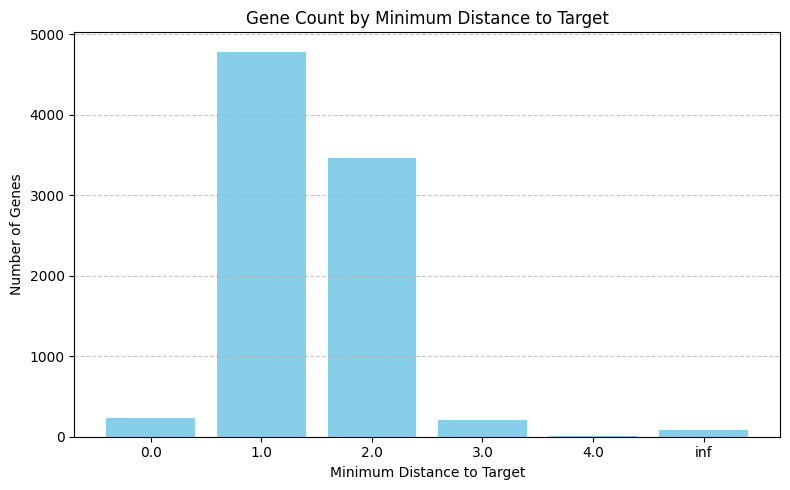

In [ ]:
import matplotlib.pyplot as plt
 
ranked_genes['min_distance_to_target'] = ranked_genes['min_distance_to_target'].replace(np.inf, 'inf')
distance_counts = ranked_genes['min_distance_to_target'].value_counts().sort_index(key=lambda x: [int(i) if i != 'inf' else float('inf') for i in x])

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(distance_counts.index.astype(str), distance_counts.values, color='skyblue')
plt.title("Gene Count by Minimum Distance to Target")
plt.xlabel("Minimum Distance to Target")
plt.ylabel("Number of Genes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [63]:
hypergraph1_result_df = pd.read_csv("../Methods/output/DGIDB_BIPOLAR/unidirectional_multilayer_rwr_results.csv")
# hypergraph1_result_df.columns.values[0] = 'claim_name'
# hypergraph1_result_df.columns.values[1] = 'score'

In [64]:
print(hypergraph1_result_df)

       Index     Score  ncbi_gene_id   claim_name Linked_Bipolar Linked_Cancer
0      17056  0.023005          6714          SRC          False          True
1      17461  0.021457          7124          TNF           True          True
2      17490  0.016960          7157         TP53          False          True
3       4555  0.013206          1543       CYP1A1           True          True
4       5636  0.013010           216      ALDH1A1           True          True
...      ...       ...           ...          ...            ...           ...
21976  18061  0.000039        767567   SNORD113-7            NaN           NaN
21977  18064  0.000039        767583   SNORD114-7            NaN           NaN
21978  18067  0.000039        767592  SNORD114-14            NaN           NaN
21979  18068  0.000039        767595  SNORD114-17            NaN           NaN
21980  18069  0.000039        767596  SNORD114-18            NaN           NaN

[21981 rows x 6 columns]


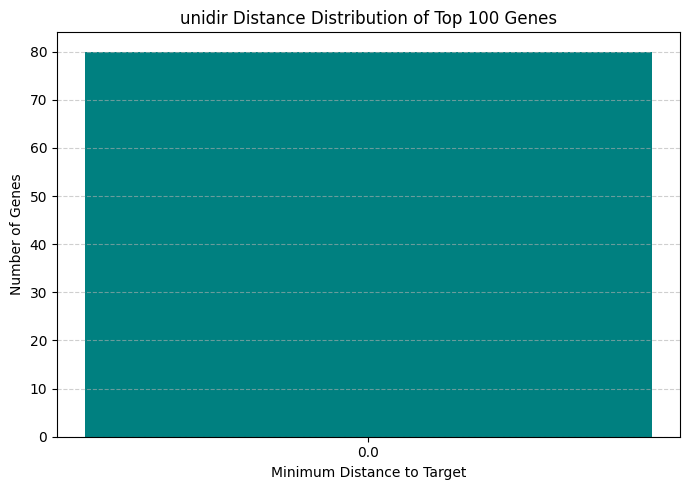

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
k = 100

# Get top-k genes
top_k_genes = hypergraph1_result_df["claim_name"].head(k)

# Filter only those genes that exist in ranked_genes index
valid_genes = top_k_genes[top_k_genes.isin(ranked_genes.index)]

# Get distances for valid genes
top_k_distances = ranked_genes.loc[valid_genes, "min_distance_to_target"]

# Replace inf with a string for labeling
top_k_distances = top_k_distances.replace(np.inf, 'inf')

# Count occurrences
distance_counts = top_k_distances.value_counts().sort_index(
    key=lambda x: [int(v) if v != 'inf' else float('inf') for v in x]
)

# Plotting
plt.figure(figsize=(7, 5))
plt.bar(distance_counts.index.astype(str), distance_counts.values, color='teal')
plt.xlabel("Minimum Distance to Target")
plt.ylabel("Number of Genes")
plt.title(f"unidir Distance Distribution of Top {k} Genes")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [66]:
import numpy as np

def dcg_at_k(relevance, k):
    relevance = np.asfarray(relevance)[:k]
    if relevance.size == 0:
        return 0.0
    return np.sum((2**relevance - 1) / np.log2(np.arange(2, relevance.size + 2)))

def ndcg_at_k(y_true, y_pred, k):
    # Sort by predicted scores
    order = np.argsort(y_pred)[::-1]
    true_sorted_by_pred = np.take(y_true, order)

    # Ideal ranking (sorted by true relevance)
    ideal_order = np.argsort(y_true)[::-1]
    ideal_sorted = np.take(y_true, ideal_order)

    dcg = dcg_at_k(true_sorted_by_pred, k)
    idcg = dcg_at_k(ideal_sorted, k)
    return dcg / idcg if idcg > 0 else 0.0

# Example
y_true = [3, 2, 3, 0, 1]
y_pred = [2, 3, 0, 1, 3]

ndcg = ndcg_at_k(y_true, y_pred, k=5)
print(f"NDCG@5 (manual): {ndcg:.4f}")


NDCG@5 (manual): 0.6818
